# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021


### Agenda

1. EDA Walmart M5 Dataset
2. Hierarchical Regression based on Calendar features


In [1]:
%load_ext nb_black
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

<IPython.core.display.Javascript object>

In [51]:
import os
from scipy import stats
import pandas as pd
import numpy as np
from typing import Dict

# ML libraries
import pymc3 as pm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

# Custom libraries
from feature_factory import FeatureFactory

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

In [3]:
P_ROOT = "../../../hts-forecast/volume/m5-forecasting-accuracy/"
df_sales = pd.read_parquet(os.path.join(P_ROOT, "walmart_m5_sales_dep_state.parquet"))
df_sales.head()

,cat_id,dept_id,state_id,date,qty
0,FOODS,FOODS_1,CA,2011-01-29,1157
1,FOODS,FOODS_1,CA,2011-01-30,1142
2,FOODS,FOODS_1,CA,2011-01-31,787
3,FOODS,FOODS_1,CA,2011-02-01,743
4,FOODS,FOODS_1,CA,2011-02-02,729


<IPython.core.display.Javascript object>

### Visualize the time Series

In [6]:
df_sales_state = (
    df_sales.pivot_table(
        index=["cat_id", "dept_id", "date"], columns="state_id", values="qty"
    )
    .reset_index()
    .set_index("date")
    .rename_axis(None, axis=0)
)
df_sales_state.head()

state_id,cat_id,dept_id,CA,TX,WI
2011-01-29,FOODS,FOODS_1,1157,500,686
2011-01-30,FOODS,FOODS_1,1142,446,628
2011-01-31,FOODS,FOODS_1,787,381,489
2011-02-01,FOODS,FOODS_1,743,317,448
2011-02-02,FOODS,FOODS_1,729,297,183


<IPython.core.display.Javascript object>

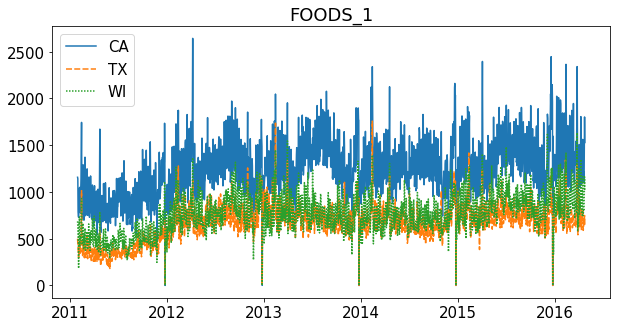

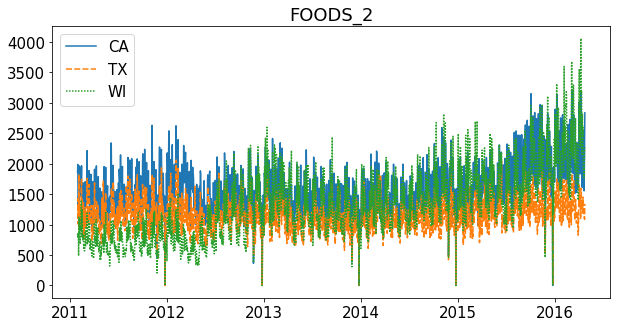

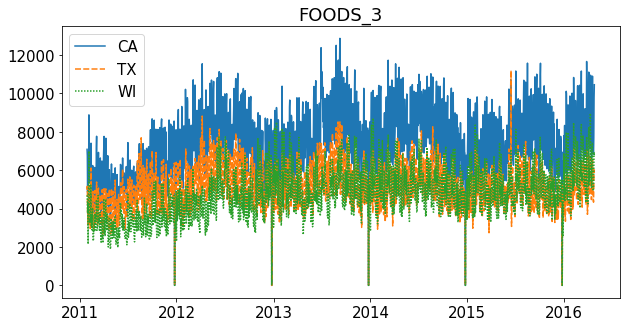

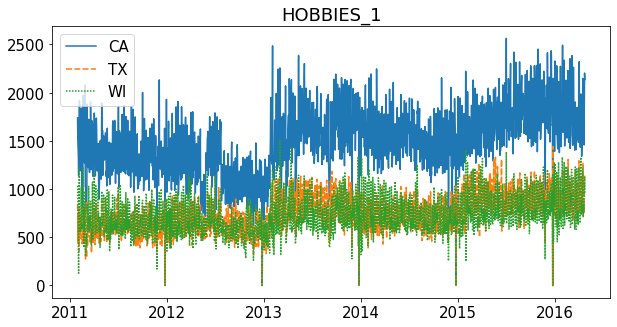

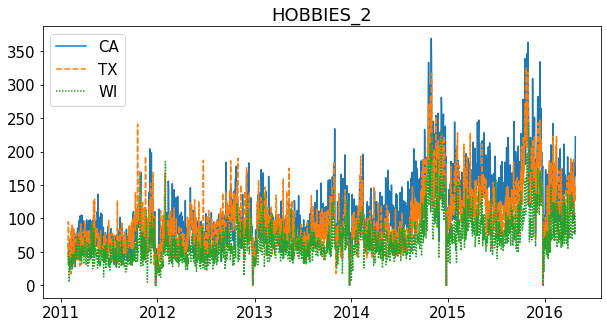

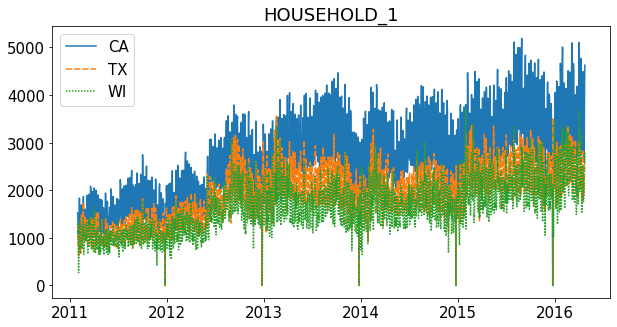

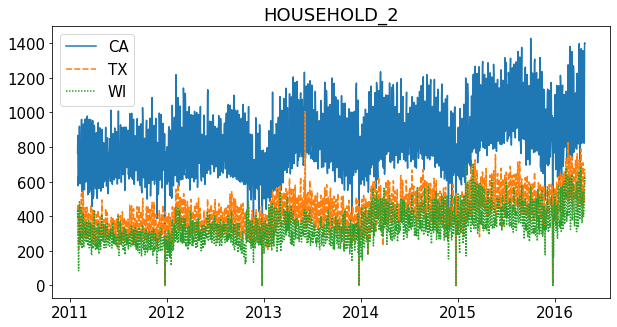

<IPython.core.display.Javascript object>

In [7]:
for name, df_grp in df_sales_state.groupby(["cat_id", "dept_id"]):
    sns.lineplot(data=df_grp.drop(["cat_id", "dept_id"], axis="columns"))
    plt.title("{x}".format(x=name[-1]))
    plt.legend()
    plt.show()

In [ ]:
### Use a single
# newdf = df.query('@mean <= closing_price <= @std')

In [140]:
df_foods_3 = df_sales.query("dept_id in ['FOODS_3']").query(
    "'2014-01-01' <= date <= '2014-12-31'"
)


<IPython.core.display.Javascript object>

In [ ]:
df_foods_3

In [ ]:
# Build Feature Factory

In [141]:
ff = FeatureFactory()

<IPython.core.display.Javascript object>

In [142]:
df_features = ff.calendar_features(df_foods_3)
df_features = ff.hierarchical_features(df_features, hierarchical_col="state_id")



<IPython.core.display.Javascript object>

In [143]:
df_features = df_features.set_index(["cat_id", "dept_id", "state_id", "date"])

<IPython.core.display.Javascript object>

In [144]:
df_features.head()

qty  day_of_week  week_of_month  \
cat_id dept_id state_id date                                            
FOODS  FOODS_3 CA       2014-01-01   5498            2              1   
                        2014-01-02   7149            3              1   
                        2014-01-03   8039            4              1   
                        2014-01-04   9031            5              1   
                        2014-01-05  10047            6              1   

                                    week_of_year  month  hierarchical_index  
cat_id dept_id state_id date                                                 
FOODS  FOODS_3 CA       2014-01-01             1      1                   0  
                        2014-01-02             1      1                   0  
                        2014-01-03             1      1                   0  
                        2014-01-04             1      1                   0  
                        2014-01-05             1      1                   0

<IPython.core.display.Javascript object>

In [ ]:
# Building a learning pipeline 

In [151]:
len(df_features)

1095

<IPython.core.display.Javascript object>

In [145]:
X, y = df_features[ff.features], df_features["qty"]

display(X.head())
display(y.head())

day_of_week  week_of_month  week_of_year  \
cat_id dept_id state_id date                                                   
FOODS  FOODS_3 CA       2014-01-01            2              1             1   
                        2014-01-02            3              1             1   
                        2014-01-03            4              1             1   
                        2014-01-04            5              1             1   
                        2014-01-05            6              1             1   

                                    month  
cat_id dept_id state_id date               
FOODS  FOODS_3 CA       2014-01-01      1  
                        2014-01-02      1  
                        2014-01-03      1  
                        2014-01-04      1  
                        2014-01-05      1

cat_id  dept_id  state_id  date      
FOODS   FOODS_3  CA        2014-01-01     5498
                           2014-01-02     7149
                           2014-01-03     8039
                           2014-01-04     9031
                           2014-01-05    10047
Name: qty, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# Sklearn pipeline
# Column Transformer
# Model
# k-fold cross-validation (or time series cross-val)
# hyper-parameter tuning

In [135]:
mod = LinearRegression()
mod.fit(X, y)
yhat = mod.predict(X)

<IPython.core.display.Javascript object>

(500, 100)

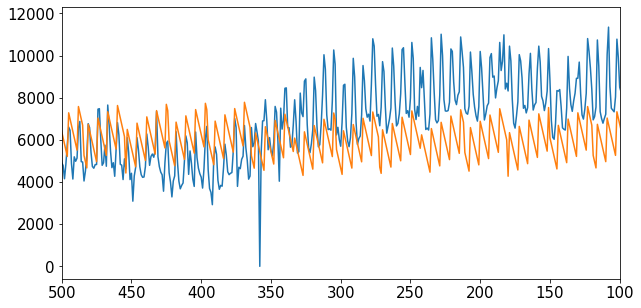

<IPython.core.display.Javascript object>

In [136]:
plt.plot(y.reset_index()["qty"])
plt.plot(yhat)
plt.xlim([500, 100])

In [171]:
n_features = len(ff.features)
n_hierarchies = X.reset_index()["state_id"].nunique()

index_rows = tuple(np.arange(len(df_features)))
index_cols = tuple(df_features["hierarchical_index"].values)


with pm.Model() as bmod:  
#     mu_w = pm.Normal("mu_w", mu=0, sigma=100, shape=(n_features, 1))
#     sig_w = pm.HalfNormal("sig_w", 100)
    
    w = pm.Normal("w", mu=0, sigma=100, shape=(n_features, n_hierarchies))
    
    sig_obs = pm.HalfNormal("sig_obs", 100)
    
    mu = (X.values @ w) [index_rows, index_cols]
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sig_obs, observed=y.values)
    
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_obs, w]
INFO:pymc3:NUTS: [sig_obs, w]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 245 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 245 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [174]:
with bmod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",881.096,36.500,815.089,951.572,0.505,0.358,5218.0,5187.0,5212.0,2684.0,1.0
"w[0,1]",611.168,35.692,541.561,674.133,0.525,0.371,4616.0,4616.0,4625.0,2749.0,1.0
"w[0,2]",561.727,35.625,492.959,629.159,0.498,0.354,5117.0,5064.0,5143.0,2890.0,1.0
"w[1,0]",779.128,42.450,695.227,853.829,0.596,0.422,5072.0,5057.0,5078.0,2950.0,1.0
"w[1,1]",447.480,43.043,364.613,525.094,0.599,0.424,5159.0,5159.0,5164.0,2866.0,1.0
"w[1,2]",503.920,43.403,422.537,584.653,0.615,0.435,4985.0,4983.0,4993.0,3127.0,1.0
"w[2,0]",-11.457,15.193,-39.794,16.394,0.242,0.221,3937.0,2353.0,3924.0,2656.0,1.0
"w[2,1]",-19.580,15.103,-47.079,9.746,0.235,0.193,4128.0,3077.0,4126.0,2875.0,1.0
"w[2,2]",-8.074,14.965,-36.728,18.400,0.247,0.217,3665.0,2374.0,3683.0,2982.0,1.0
"w[3,0]",363.106,62.324,249.600,480.799,1.015,0.731,3774.0,3633.0,3776.0,2643.0,1.0


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


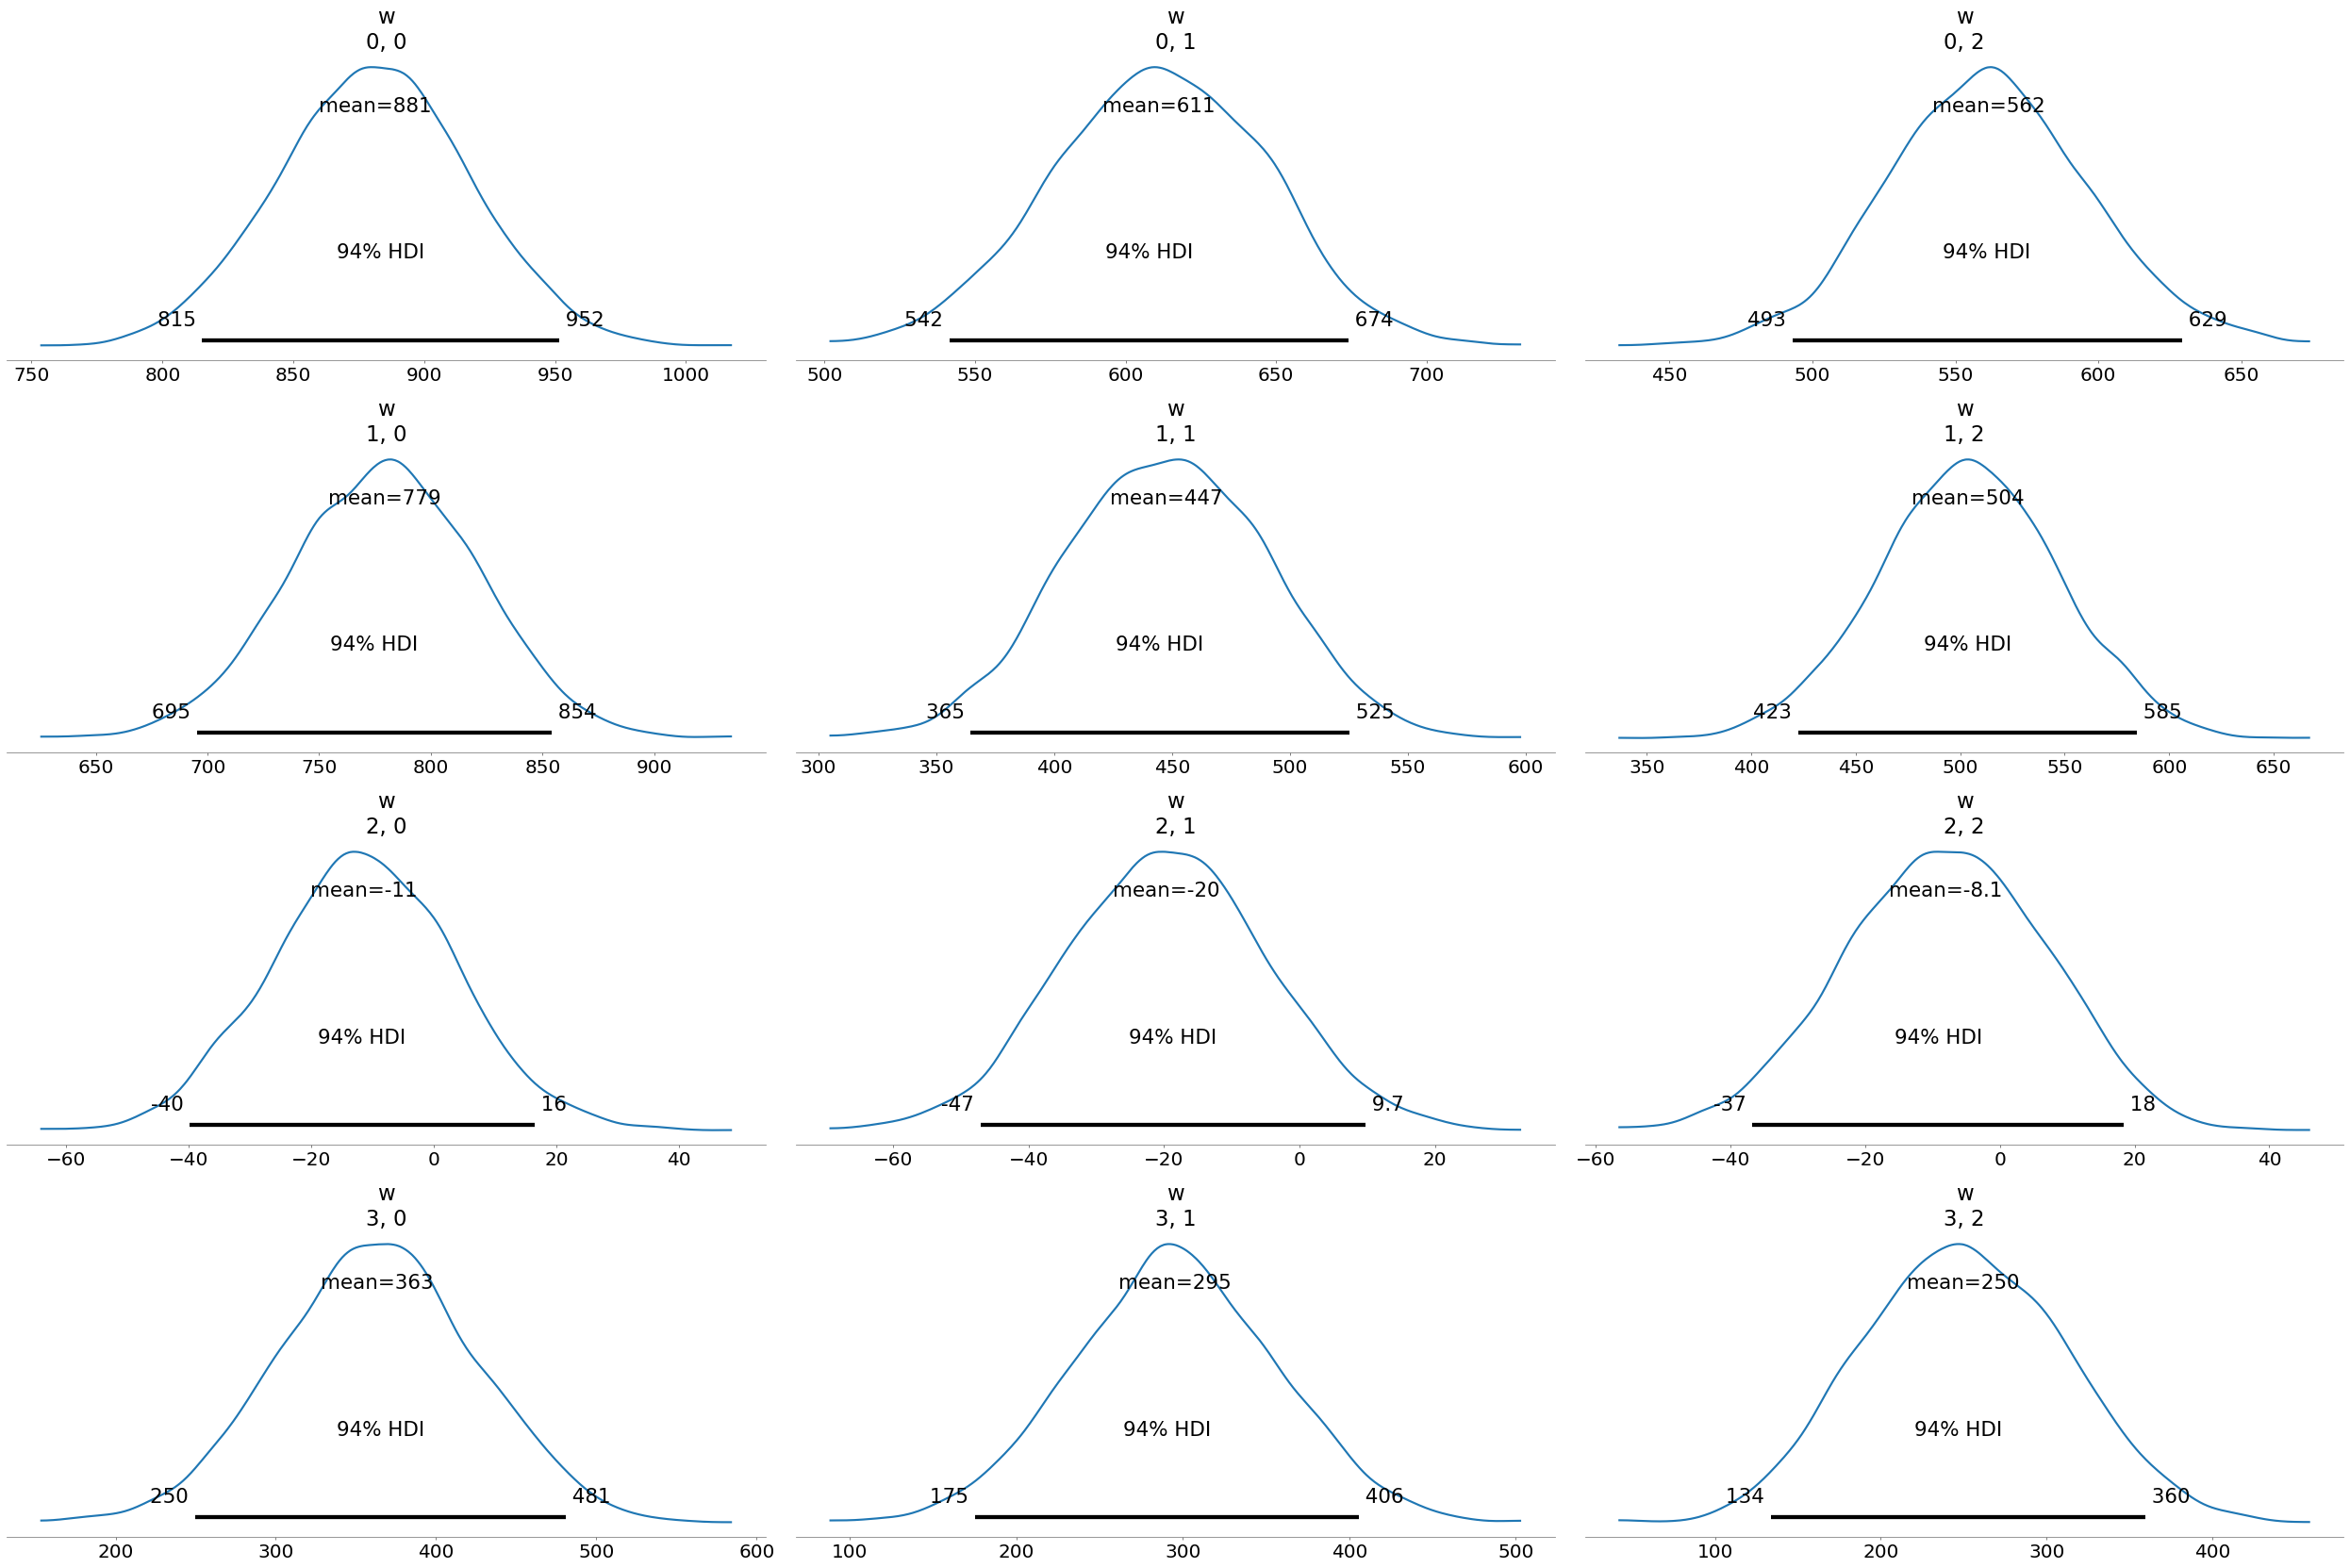

<IPython.core.display.Javascript object>

In [179]:
pm.plot_posterior(trace, var_names=["w"], textsize=20)
plt.show()

In [190]:
trace.get_values(varname="w").mean(axis=0)

array([[881.09620496, 611.16756299, 561.72707323],
       [779.12833712, 447.47996526, 503.9204668 ],
       [-11.45668662, -19.58008865,  -8.07400715],
       [363.10594479, 295.00729986, 249.81620767]])

<IPython.core.display.Javascript object>

In [ ]:
n_features = len(ff.features)
n_hierarchies = X.reset_index()["state_id"].nunique()

index_rows = tuple(np.arange(len(df_features)))
index_cols = tuple(df_features["hierarchical_index"].values)


with pm.Model() as bmod:  
#     mu_w = pm.Normal("mu_w", mu=0, sigma=100, shape=(n_features, 1))
#     sig_w = pm.HalfNormal("sig_w", 100)
    
    w = pm.Normal("w", mu=0, sigma=100, shape=(n_features, n_hierarchies))
    
    sig_obs = pm.HalfNormal("sig_obs", 100)
    
    mu = (X.values @ w) [index_rows, index_cols]
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sig_obs, observed=y.values)
    
    trace = pm.sample(draws=2000)